# Linear and Logistic Regression
We will also compare the generalization error by these models

In [21]:
#Imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cvxopt as cpt
from cvxopt import matrix, solvers
import keras
from sklearn.model_selection import LeaveOneOut
import cvxpy as cp

# Dataset
Will check generalization error with a 2d synthetic dataset and MNIST data

In [31]:
# generate two-dimensional synthetic data based on mean and variance
def synthetic_data(mean1, mean2, cov, seed):
    np.random.seed(seed)
    X1 = np.random.multivariate_normal(mean1, cov, 200)
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, 200)
    y2 = np.ones(len(X2)) * -1
    X_n = np.concatenate((X1, X2), axis=0)
    y_n = np.concatenate((y1, y2))

    return X_n, y_n

#To get the MNIST data of class 0 and class 1
def mnist_data():

    # Load the Data MNIST from keras
    num_classes = 10
    mnist = keras.datasets.mnist
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train / 255.0
    x_test = x_test / 255.0

    #Preprocess to get the data dimension as 28*28 = 784
    x_train1 = []
    x_test1 = []
    for i in range(x_train.shape[0]):
        x_train1.append(x_train[i].flatten())

    for i in range(x_test.shape[0]):
        x_test1.append(x_test[i].flatten())
    x_train = np.array(x_train1)
    x_test = np.array(x_test1)

    # Getting the 0 and 1 training samples
    train_labels = y_train
    x_train_label0_inds = [i for i in range(len(train_labels)) if train_labels[i] == 0]
    x_train_label1_inds = [i for i in range(len(train_labels)) if train_labels[i] == 1]
    x_train_label_0_and_1_inds = x_train_label0_inds + x_train_label1_inds

    X = x_train[x_train_label_0_and_1_inds]
    y1 = y_train[x_train_label_0_and_1_inds]

    #Set the class as +1 or -1
    y = []
    for i in y1:
        if (i == 0):
            y.append(-1.0)
        else:
            y.append(1.0)
    y = np.array(y)

    # For test case, creating the 0 and 1 test samples similarly
    test_labels = y_test
    x_test_label0_inds = [i for i in range(len(test_labels)) if test_labels[i] == 0]
    x_test_label1_inds = [i for i in range(len(test_labels)) if test_labels[i] == 1]
    x_test_label_0_and_1_inds = x_test_label0_inds + x_test_label1_inds

    X_t = x_test[x_test_label_0_and_1_inds]
    y_t1 = y_test[x_test_label_0_and_1_inds]

    y_t = []
    for i in y_t1:
        if (i == 0):
            y_t.append(-1.0)
        else:
            y_t.append(1.0)
    y_t = np.array(y_t)

    return X, y, X_t, y_t

# Data Exploration

In [32]:
#Get the 2D Synthetic dataset and mnist train and test set of class 0 and 1

#The required parameters to send for synthetic data
seed = 65260 #Last five digit of the Lib#
mean1 = np.array([-1, -1])
mean2 = np.array([1, 1])
cov = np.array([[1, 0], [0, 1]])

X_n, y_n = synthetic_data(mean1, mean2, cov, seed) #For synthetic 2d data
X, y, X_t, y_t = mnist_data() #For mnist data

#print the shapes of the loaded dataset
print(X_n.shape)
print(y_n.shape)
print(X.shape)
print(y.shape)
print(X_t.shape)
print(y_t.shape)

(400, 2)
(400,)
(12665, 784)
(12665,)
(2115, 784)
(2115,)


# Linear Regression
Implementation and error analysis. We will also show the necessary plots.

In [ ]:
#Answer to Question 2(a)

In [10]:
#Getting the parameters by following the equation of w_hat
#Make the data ready for example append column 1 at X and reshape y
def append_1_column_and_reshape(X_n, y_n):
    y_n = y_n.reshape((len(y_n), 1))
    X_n_appended_1 = np.insert(X_n, 0, 1., axis=1)
    #print(X_n_appended_1.shape)
    #print(np.linalg.det(np.dot(X_n_appended_1.T,X_n_appended_1)))
    return X_n_appended_1, y_n

In [11]:
#The linear regression function returns the parameters based on the equation
def linear_reg(X, y):    
    w_hat = np.dot(np.dot(np.linalg.inv(np.dot(X.T,X)), X.T), y)
    #w_hat = np.dot(np.dot(np.linalg.pinv(np.dot(X.T,X)), X.T), y) #For mnist pseudoinverse
    return w_hat

In [28]:
#The linear regression function returns the parameters based on the equation
def linear_reg_mnist(X, y):    
    w_hat = np.dot(np.dot(np.linalg.pinv(np.dot(X.T,X)), X.T), y) #For mnist pseudoinverse
    return w_hat

In [12]:
#Define the function of making a binary classifier by thresholding the output at 0
def binary_classifier(X, w_hat, labels):
    dot_X_w1_hat_plus_w0 = np.dot(X, w_hat.T)
    y_pred = np.copy(dot_X_w1_hat_plus_w0)
    y_pred [y_pred >= 0.0] = 0
    y_pred [y_pred <0.0] = -1
    y_pred [y_pred == 0.0] = 1
    num_of_correct = np.sum(y_pred.flatten() == labels.flatten())
    #print('Total number of predictions correct: ', num_of_correct)
    error = np.sum(np.abs((y_pred.flatten() - labels.flatten())/2)) / float(np.size(labels)) #we need dividing by 2 because classes are not 0 and 1, it's -1 and +1
    return error

In [53]:
#loo computation for linear regression
def loo_cv_linear_reg(X, y):
    error_loo_all = []
    loo = LeaveOneOut()
    for train, test in loo.split(X):
        X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
        w_hat_loo = linear_reg(X_train,y_train)
        error_loo = binary_classifier(X_test, w_hat_loo.T, y_test)
        error_loo_all.append(error_loo)
    #print(error_loo_all)
    error_loo_all_np = np.array(error_loo_all)
    return np.mean(error_loo_all_np)

In [16]:
#Get the parameters by calling linear_reg function
#append column 1 with X and reshape y
X_1,y_r = append_1_column_and_reshape(X_n, y_n)
w_hat = linear_reg(X_1, y_r)
#error = binary_classifier(X_n_appended_1, w_hat.T, y)
#print('error on the dataset: ', error)
print('Parameters w_hat for linear regression is:\n', w_hat)

Parameters w_hat for linear regression is:
 [[ 0.02435442]
 [-0.38001979]
 [-0.31971653]]


# Plot Decision Boundary

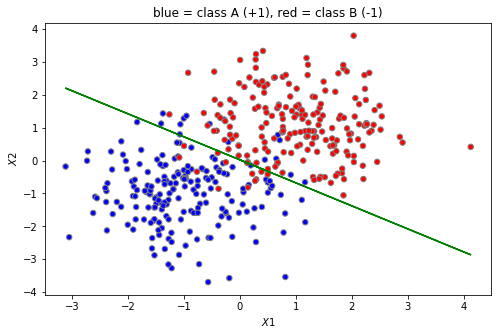

In [20]:
# plotting the decision boundary for linear regression
fig = plt.figure(figsize=(8, 5))
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.scatter(X_n[:,0], X_n[:,1], edgecolors='gray', facecolors=['red' if y_i == -1 else 'blue' for y_i in y_n], s=30)
y_eqn = w_hat[0][0]*X[:,0] + w_hat[1][0]*X[:,1] + w_hat[2][0]*X[:,1]
plt.plot(X_n[:,0] , y_eqn, '-g')
plt.xlabel('$X1$')
plt.ylabel('$X2$')
plt.title('blue = class A (+1), red = class B (-1)')
#plt.savefig('./ml_prog_assignment_1/prog1_results/linear_reg_2d_data.pdf')
plt.show()

In [25]:
#Get the leave-one-out error with the linear regression classifier
#append column 1 with X and reshape y
X_1,y_r = append_1_column_and_reshape(X_n, y_n)
loo_err = loo_cv_linear_reg(X_1, y_r)
print('Leave one out error on the 2d set with linear regression is: ', loo_err)

Leave one out error on the 2d set with linear regression is:  0.065


In [35]:
#To compute the generalization error with MNIST dataset
#Get the parameters by calling linear_reg function
X_1,y_r = append_1_column_and_reshape(X, y)
w_hat_mnist = linear_reg_mnist(X_1,y_r)
print('w_hat shape for mnist_train: ', w_hat_mnist.shape)

X_t_1,y_t_r = append_1_column_and_reshape(X_t, y_t)
gen_error = binary_classifier(X_t_1, w_hat_mnist.T, y_t_r)
print('Generalization error on the mnist test set with linear regression classifier is : ', gen_error)

w_hat shape for mnist_train:  (785, 1)
Generalization error on the mnist dataset with linear regression classifier is :  0.006146572104018913


# Logistic Regression
Implementation and error analysis. We will also show the necessary plots.

In [43]:
#Answer to Question 2(b)
#Need to import cvxpy for convex optimization

In [42]:
#Get the error when it is called with the dot of X and w_vals along with labels
def error(dot_prods, labels):
    dot_prods[dot_prods > 0] = 1
    dot_prods[dot_prods <= 0] = 0
    return np.sum(np.abs(dot_prods - labels)) / float(np.size(labels))

In [45]:
def logistic_reg(X, Y):
    #how many variables
    n = X.shape[1]
    #set -1 class as 0
    Y = Y.flatten()
    Y[Y == -1] = 0
    #Set the convex optimization problem
    looping = 1
    train_error = np.zeros(looping)
    test_error = np.zeros(looping)
    w_vals = cp.Variable(n)
    log_likelihood = cp.sum( cp.multiply(Y, X @ w_vals) - cp.logistic(X @ w_vals) )
    problem = cp.Problem(cp.Maximize(log_likelihood/n ))
    w_vals_vals = []
    #Number of tries
    for i in range(looping):
        problem.solve(verbose = False, max_iters=5000) #max_iters set at 5000
        train_error[i] = error( (X @ w_vals).value, Y)
        #test_error= error( (X_test @ w_vals).value, Y_test)
        w_vals_vals.append(w_vals.value)
    #It is possible to save the w_vals, the parameters
    #np.save('./ml_prog_assignment_1/cvxpy_lr_w_vals_value_w', w_vals.value)
    #np.save('./ml_prog_assignment_1/cvxpy_lr_w_vals_value_2d_w', w_vals.value)
    #print(train_error)
    #print(test_error)
    return  w_vals.value

In [55]:
def loo_cv_logistic_reg(X, y):
    error_loo_all = []
    loo = LeaveOneOut()
    for train, test in loo.split(X):
        X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
        w_hat_loo = logistic_reg(X_train,y_train)
        #print('\n',w_hat_loo)
        error_loo = binary_classifier(X_test, w_hat_loo.T, y_test)
        error_loo_all.append(error_loo)
    error_loo_all_np = np.array(error_loo_all)
    return np.mean(error_loo_all_np)


In [49]:
#Get the parameters by calling logistic_reg function
#append column 1 with X and reshape y
X_1,y_r = append_1_column_and_reshape(X_n, y_n)
w_hat = logistic_reg(X_1, y_r)
w_hat = w_hat[:, np.newaxis]
#error = binary_classifier(X_n_appended_1, w_hat.T, y)
#print('error on the dataset: ', error)
print('Parameters w_hat for linear regression is:\n', w_hat)

Parameters w_hat for linear regression is:
 [[ 0.2054023 ]
 [-2.41224933]
 [-2.29302264]]


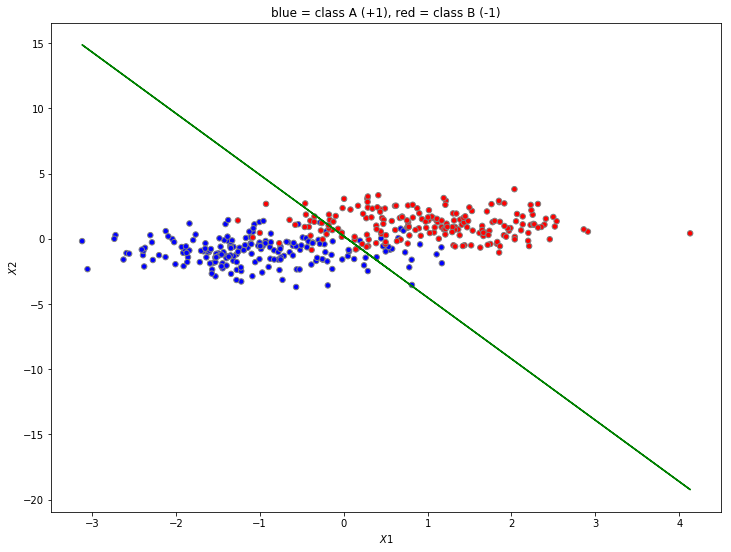

In [51]:
# plot the decision boundary for logistic regression
#w_hat = np.array([ 0.2054023, -2.41224933, -2.29302264])
#w_hat = w_hat[:, np.newaxis]
fig = plt.figure(figsize=(12, 9))
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.scatter(X_n[:,0], X_n[:,1], edgecolors='gray', facecolors=['red' if y_i == -1 else 'blue' for y_i in y_n], s=30)

y_eqn = w_hat[0][0]*X_1[:,0] + w_hat[1][0]*X_1[:,1] + w_hat[2][0]*X_1[:,1]
plt.plot(X_1[:,1] , y_eqn, '-g')
plt.xlabel('$X1$')
plt.ylabel('$X2$')
plt.title('blue = class A (+1), red = class B (-1)')
#plt.savefig('./ml_prog_assignment_1/prog1_results/logistic_reg_2d_data.pdf')

plt.show()

In [54]:
#Get the leave-one-out error with the logistic regression classifier
#append column 1 with X and reshape y
X_1,y_r = append_1_column_and_reshape(X_n, y_n)
loo_err = loo_cv_logistic_reg(X_1, y_r)
print('Leave one out error on the 2d set with logistic regression is: ', loo_err)

Leave one out error on the 2d set with logistic regression is:  0.065


# With MNIST Dataset

In [ ]:
#To compute the generalization error with MNIST dataset with logistic regression
#Get the parameters by calling linear_reg function
X_1,y_r = append_1_column_and_reshape(X, y)
w_hat_mnist = logistic_reg(X_1,y_r)
print('w_hat shape for mnist_train: ', w_hat_mnist.shape)

X_t_1,y_t_r = append_1_column_and_reshape(X_t, y_t)
gen_error = binary_classifier(X_t_1, w_hat_mnist.T, y_t_r)
print('Generalization error on the mnist test set with logistic regression classifier is : ', gen_error)

In [57]:
#It is also possible to load the saved parameters of logistic regression and get the test error
lr_coef = np.load('./ml_prog_assignment_1/cvxpy_lr_beta_value_w.npy') #for mnist
#lr_coef = np.load('./ml_prog_assignment_1/cvxpy_lr_beta_value_2d_w.npy') #for 2d
lr_coef = lr_coef[:,np.newaxis]

X_t_1,y_t_r = append_1_column_and_reshape(X_t, y_t)
gen_error= binary_classifier(X_t_1, lr_coef.T, y_t_r)
print('Generalization error on the mnist test set with logistic regression classifier is : ', gen_error)

Generalization error on the mnist test set with logistic regression classifier is :  0.002364066193853428


In [ ]:
#Answer to the quetion 2(c)
#Actually the answer is already given in the other parts where we got the generalization error on MNIST test set